In [2]:
import Project_library
import jax
import jax.numpy as jnp

In [3]:
min_observation = jnp.deg2rad(30)
# Calculate the visible area, given the minimum observational angle

# Only works when at equator
def visible_angle(min_observation, satellite_position : jnp.ndarray) -> tuple[float, float, float, float, float, float]:
    """Calculate the visible angle area of a satellite given its position.

    Args:
        min_observation (float): The minimum observational angle in radians.
        satellite_position (jnp.ndarray): The position of the satellite in Cartesian coordinates.

    Returns:
        tuple: A tuple containing the visible area and the radius of the visible area.
    """
    # Calculate the distance from the satellite to the center of the Earth
    distance = jnp.linalg.norm(satellite_position)
    # Calculate the radius of the Earth
    earth_radius = 6371  # in km

    #
    bing = jnp.sin(min_observation+jnp.pi/2)

    print(bing)

    # Calculate the angle of the satellite
    alpha = jnp.arcsin(earth_radius*bing/distance)
    # Calculate the angle from the center of the earth
    lat_width = jnp.pi/2 - alpha - min_observation

    # Calculate the spherical value of the satellite
    radius, longitude, latitude = pl.cartesian_to_spherical(*satellite_position)
    
    # Define the ranges of the visible area
    lat_range = (latitude.item() - lat_width, latitude.item() + lat_width)
    lon_range = (longitude.item() - lat_width, longitude.item() + lat_width)

    print(longitude, latitude, lat_range, lon_range)


    return lat_range, lon_range, radius, alpha, distance, lat_width

In [23]:
#@jax.jit
def calculate_if_cell_within_visible_area(
        cell_latitude_list: float,
        cell_longitude_list: float,
        satellite_latitude: float,
        satellite_longitude: float,
        satellite_height: float,
        alpha : float,
        earth_radius: float = 6371.0) -> bool:
    """Check if a cell is within the visible area of a satellite.

    """
    
    phi_s, lam_s, alpha = jnp.deg2rad(jnp.asarray([satellite_latitude, satellite_longitude, alpha]))
    cos_alpha  = jnp.cos(alpha)

    # Make into a tensor
    phi_c  = jnp.deg2rad(cell_latitude_list)[:, None]          # (N,1)
    lam_c  = jnp.deg2rad(cell_longitude_list)[None, :]          # (1,M)

    sin_phi_s, cos_phi_s = jnp.sin(phi_s), jnp.cos(phi_s)
    sin_phi_c, cos_phi_c = jnp.sin(phi_c), jnp.cos(phi_c)

    # Calculate the angle from the center of the earth
    cos_dsigma = (sin_phi_s * sin_phi_c +
                  cos_phi_s * cos_phi_c * jnp.cos(lam_c - lam_s))
    
    # Calculate the conditional
    return cos_dsigma >= cos_alpha
    

visible_area = calculate_if_cell_within_visible_area(cell_latitude_list=jnp.deg2rad(jnp.linspace(-10,10,100)),
                                    cell_longitude_list=jnp.deg2rad(jnp.linspace(-10,10,100)),
                                    satellite_latitude=jnp.deg2rad(0),
                                    satellite_longitude=jnp.deg2rad(0),
                                    satellite_height=6000,
                                    alpha=jnp.deg2rad(10),
                                    earth_radius=6371.0
)



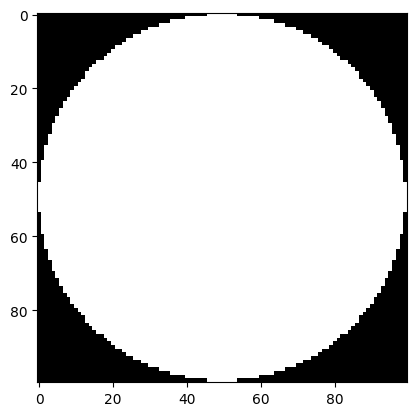

In [24]:
import matplotlib.pyplot as plt
plt.imshow(visible_area, cmap='gray')